# Analysis of the online model

In [2]:
from __future__ import annotations

import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import json
from typing import List

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.extra.io import save_plot

matplotlib.rcParams['font.family'] = "monospace"
%matplotlib inline

### Old results

In [3]:
folder = '../data/old/online'
for filename in os.listdir(folder):
    if 'online' in filename:
        with open(f'{folder}/{filename}') as file:
            json_data = json.load(file)
            print(f'{filename}: {len(json_data)}')

batch_online_paper_r_s8_dt07-27_00-30-22.json: 20
batch_online_paper_r_s6_dt07-27_00-30-22.json: 20
batch_online_paper_r_s8_dt07-31_10-07-43.json: 20
batch_online_paper_r_s8_dt07-18_01-20-21.json: 4
batch_online_paper_r_s6_dt07-24_13-00-33.json: 1


### New results

In [4]:
folder = '../data/online'
filenames = sorted(os.listdir(folder))
for filename in filenames:
    if 'online' in filename:
        with open(f'{folder}/{filename}') as file:
            json_data = json.load(file)
            print(f'{filename}: {len(json_data)}')

batch_online_alibaba_r_s4_dt07-06_16-49-58.json: 3
batch_online_alibaba_r_s4_dt07-09_10-49-53.json: 20
batch_online_alibaba_r_s4_dt07-16_15-22-45.json: 6
batch_online_alibaba_r_s4_dt07-17_13-48-14.json: 12
batch_online_alibaba_r_s4_dt07-19_12-20-33.json: 20
batch_online_alibaba_r_s4_dt07-19_14-11-01.json: 10
batch_online_alibaba_r_s6_dt07-12_23-39-50.json: 7
batch_online_synthetic_r_s4_dt06-29_13-26-32.json: 20
batch_online_synthetic_r_s4_dt07-09_10-49-53.json: 20
batch_online_synthetic_r_s6_dt07-01_16-24-33.json: 4
batch_online_synthetic_r_s6_dt07-09_10-49-53.json: 20


In [5]:
results_filename = f'{folder}/{filenames[-1]}'

with open(results_filename) as file:
    results_data = json.load(file)

In [6]:
batch_lengths = [batch_length for batch_length in results_data[0].keys() if batch_length != 'model']
algos = list(results_data[0]['batch length 1'].keys())
algo_names = ['Non-elastic Optimal', 'Greedy Algorithm']
{'Batch length': batch_lengths, 'Algorithms': algos, 'Algo Names': algo_names}

{'Batch length': ['batch length 1', 'batch length 3', 'batch length 6'],
 'Algorithms': ['Non-elastic Optimal',
  'Greedy Utility * deadline / Sum, Product, Pow percent sum'],
 'Algo Names': ['Non-elastic Optimal', 'Greedy Algorithm']}

### Task arrival over time

In [7]:
model_tasks = results_data[0]['model']['tasks']
max_auction_time = max(task['auction time'] for task in model_tasks) + 1
max_auction_time

250

(0.0, 250.0)

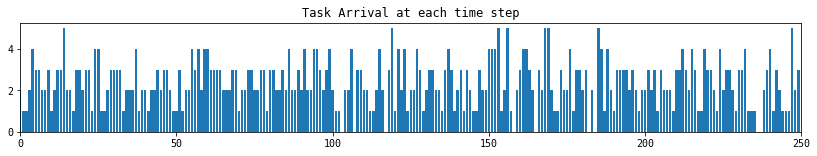

In [8]:
tasks_per_time_step = [
    sum(task['auction time'] == time_step for task in model_tasks)
    for time_step in range(max_auction_time)
]

_, ax_task_arrival = plt.subplots(figsize=(14, 2))
ax_task_arrival.bar(np.arange(max_auction_time), tasks_per_time_step)
ax_task_arrival.set_title('Task Arrival at each time step')
ax_task_arrival.set_xlim(0, max_auction_time)

### Resource batch results

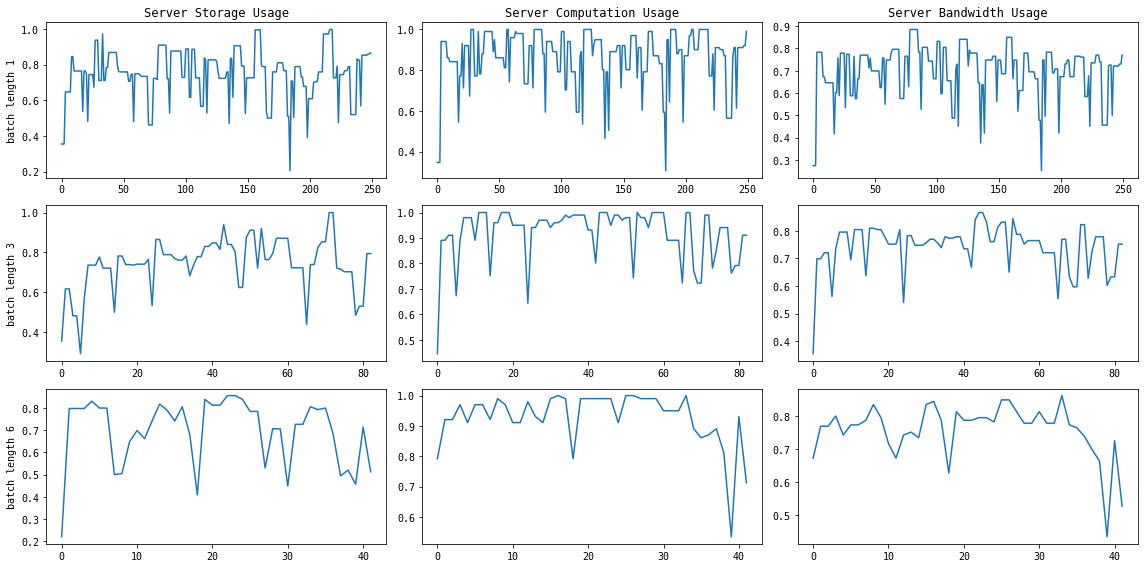

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(16, 8))
for pos, title in enumerate(('Server Storage Usage', 'Server Computation Usage', 'Server Bandwidth Usage')):
    axs[0][pos].set_title(title)
    
for ax, batch_length in zip(axs, batch_lengths):
    ax[0].set_ylabel(batch_length)
    batch_time_steps = len(results_data[0][batch_length][algos[0]]['server storage used']['server 0'])
    for resource_ax, resource in zip(ax, ('server storage used', 'server computation used', 'server bandwidth used')):
        resource_ax.plot(np.arange(batch_time_steps), results_data[0][batch_length][algos[0]][resource]['server 0'])
        
plt.tight_layout()

## Overall results

In [10]:
for filename in filenames:
    print(f'\n{filename}')
    with open(f'{folder}/{filename}') as file:
        results_data = json.load(file)
        
    batch_lengths = [batch_length for batch_length in results_data[0].keys() if 'model' not in batch_length]
    for algo in algos:
        print(f'Algorithm: {algo}')
        for batch_length in batch_lengths:
            tasks_allocated = np.mean([result[batch_length][algo]['percentage tasks allocated'] 
                                       for result in results_data])
            social_welfare = np.mean([result[batch_length][algo]['social welfare'] 
                                      for result in results_data])
            social_welfare_percent = np.mean([result[batch_length][algo]['social welfare percent']
                                              for result in results_data])
            print(f'\t{batch_length.title()} - Tasks allocated: {tasks_allocated:.3f}, '
                  f'social welfare: {social_welfare:.3f}, social welfare percent: {social_welfare_percent:.3f}')

    print('Performance difference in social welfare for the non-elastic optimal vs elastic greedy algorithm')
    for batch_length in batch_lengths:
        performance_difference = np.mean([
            result[batch_length]['Non-elastic Optimal']['social welfare'] / result[batch_length][algos[1]]['social welfare']
            for result in results_data])
        print(f'\t{batch_length.title()} - {performance_difference:.3f}')



batch_online_alibaba_r_s4_dt07-06_16-49-58.json
Algorithm: Non-elastic Optimal
	Batch Length 1 - Tasks allocated: 0.247, social welfare: 16982.377, social welfare percent: 0.203
	Batch Length 3 - Tasks allocated: 0.238, social welfare: 19240.490, social welfare percent: 0.230
	Batch Length 6 - Tasks allocated: 0.213, social welfare: 19974.267, social welfare percent: 0.239
Algorithm: Greedy Utility * deadline / Sum, Product, Pow percent sum
	Batch Length 1 - Tasks allocated: 0.245, social welfare: 16307.010, social welfare percent: 0.195
	Batch Length 3 - Tasks allocated: 0.208, social welfare: 15725.277, social welfare percent: 0.188
	Batch Length 6 - Tasks allocated: 0.163, social welfare: 13978.837, social welfare percent: 0.167
Performance difference in social welfare for the non-elastic optimal vs elastic greedy algorithm
	Batch Length 1 - 1.042
	Batch Length 3 - 1.224
	Batch Length 6 - 1.430

batch_online_alibaba_r_s4_dt07-09_10-49-53.json
Algorithm: Non-elastic Optimal
	Batch L

Algorithm: Non-elastic Optimal
	Batch Length 1 - Tasks allocated: 0.518, social welfare: 16955.300, social welfare percent: 0.553
	Batch Length 3 - Tasks allocated: 0.443, social welfare: 15632.150, social welfare percent: 0.513
	Batch Length 6 - Tasks allocated: 0.361, social welfare: 12412.500, social welfare percent: 0.436
Algorithm: Greedy Utility * deadline / Sum, Product, Pow percent sum
	Batch Length 1 - Tasks allocated: 0.730, social welfare: 23191.650, social welfare percent: 0.757
	Batch Length 3 - Tasks allocated: 0.616, social welfare: 20840.350, social welfare percent: 0.683
	Batch Length 6 - Tasks allocated: 0.492, social welfare: 16187.100, social welfare percent: 0.568
Performance difference in social welfare for the non-elastic optimal vs elastic greedy algorithm
	Batch Length 1 - 0.728
	Batch Length 3 - 0.747
	Batch Length 6 - 0.764


### Synthetic results

In [11]:
results_filename = f'{folder}/{filenames[-1]}'

print(results_filename)
with open(results_filename) as file:
    results_data = json.load(file)

../data/online/batch_online_synthetic_r_s6_dt07-09_10-49-53.json


In [12]:
data = [] 
batch_lengths = [batch_length for batch_length in results_data[0].keys() if 'model' not in batch_length]
for pos, result in enumerate(results_data):
    for length, length_name in zip(batch_lengths, ('Online', 'Batch Length=3', 'Batch Length=6')):
        for algo, algo_name in zip(algos, algo_names):
            data.append([length_name, algo_name, result[length][algo]['social welfare'], pos])
    
online_df = pd.DataFrame(data, columns=['Batch Length', 'Algorithm', 'Social Welfare', 'repeat'])
online_df.replace('Non-elastic Optimal', 'Non-elastic Myopic Optimal', inplace=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save file location: figs/eps/online_synthetic.eps
Save file location: figs/png/online_synthetic.png
Save file location: figs/pdf/online_synthetic.pdf


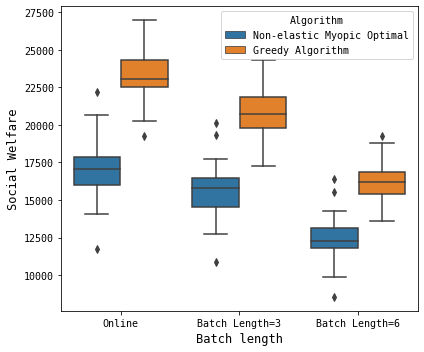

In [18]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(x='Batch Length', y='Social Welfare', hue='Algorithm', data=online_df, ax=ax)
ax.set_xlabel('Batch length', fontsize=12)
ax.set_ylabel('Social Welfare', fontsize=12)
plt.tight_layout()
save_plot('online_synthetic')

### Alibaba task time-taken 

In [14]:
import pandas as pd

df = pd.read_csv('../models/alibaba_cluster_tasks.csv')

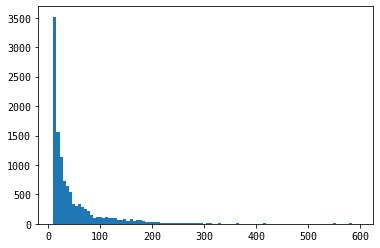

In [15]:
_ = plt.hist(df['time-taken'], bins=100)

In [16]:
np.mean(df['time-taken'])

50.282592186313394

In [17]:
results_filename = f'{folder}/batch_online_alibaba_r_s4_dt07-17_13-48-14.json'

print(results_filename)
with open(results_filename) as file:
    results_data = json.load(file)

../data/online/batch_online_alibaba_r_s4_dt07-17_13-48-14.json


In [17]:
data = [] 
batch_lengths = [batch_length for batch_length in results_data[0].keys() if 'model' not in batch_length]
batch_length_names = ['Online' if pos==0 else length.title() for pos, length in enumerate(batch_lengths)]
for pos, result in enumerate(results_data):
    for length, length_name in zip(batch_lengths, batch_length_names):
        for algo, algo_name in zip(algos, algo_names):
            data.append([length_name, algo_name, result[length][algo]['social welfare'], pos])
    
online_df = pd.DataFrame(data, columns=['Batch Length', 'Algorithm', 'Social Welfare', 'repeat'])
online_df.replace('Non-elastic Optimal', 'Non-elastic Myopic Optimal', inplace=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save file location: figs/eps/online_alibaba.eps
Save file location: figs/png/online_alibaba.png
Save file location: figs/pdf/online_alibaba.pdf


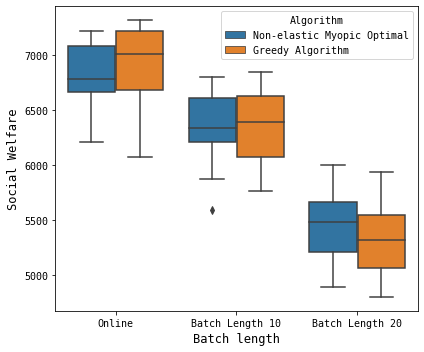

In [18]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(x='Batch Length', y='Social Welfare', hue='Algorithm', data=online_df, ax=ax)
ax.set_xlabel('Batch length', fontsize=12)
ax.set_ylabel('Social Welfare', fontsize=12)
plt.tight_layout()
save_plot('online_alibaba')

## Comparing Non-elastic and greedy online task allocation

In [19]:
result = results_data[0]
print(list(result))
print(list(result['batch length 1']))
print(list(result['batch length 1']['Non-elastic Optimal']))

['model', 'batch length 1', 'batch length 10', 'batch length 20']
['Non-elastic Optimal', 'Greedy Utility * deadline / Sum, Product, Pow percent sum']
['algorithm', 'solve time', 'social welfare', 'social welfare percent', 'percentage tasks allocated', 'server social welfare', 'server storage used', 'server computation used', 'server bandwidth used', 'server num tasks allocated']


In [20]:
result['batch length 1']['Non-elastic Optimal']['server storage used'].keys()

dict_keys(['large 0', 'large 1', 'large 2', 'large 3'])

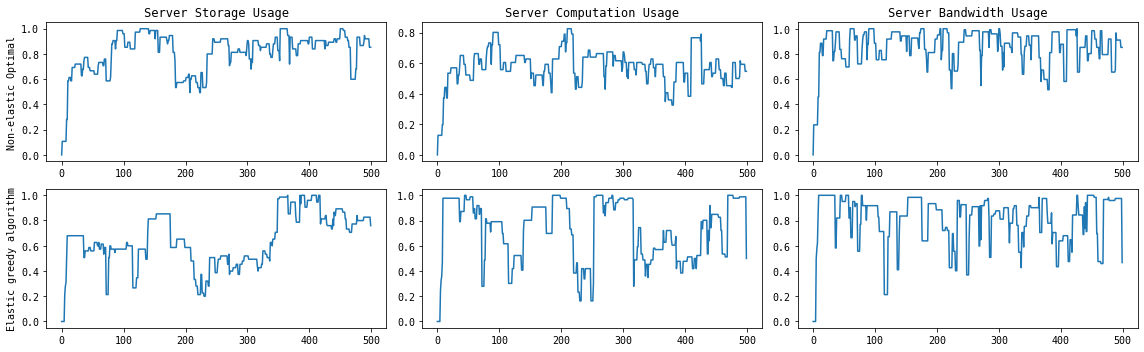

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(16, 5))
for pos, title in enumerate(('Server Storage Usage', 'Server Computation Usage', 'Server Bandwidth Usage')):
    axs[0][pos].set_title(title)
    
for ax, algo in zip(axs, algos):
    batch_time_steps = len(results_data[0][batch_lengths[0]][algo]['server storage used']['large 1'])
    for resource_ax, resource in zip(ax, ('server storage used', 'server computation used', 'server bandwidth used')):
        resource_ax.plot(np.arange(batch_time_steps), results_data[0][batch_lengths[0]][algo][resource]['large 1'])

axs[0, 0].set_ylabel('Non-elastic Optimal')
axs[1, 0].set_ylabel('Elastic greedy algorithm')
plt.tight_layout()

## Synthetic and Alibaba online modelling

Save file location: figs/eps/online_resource_allocation.eps
Save file location: figs/png/online_resource_allocation.png
Save file location: figs/pdf/online_resource_allocation.pdf


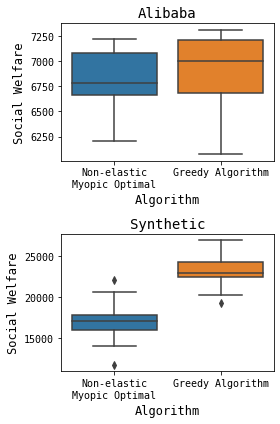

In [50]:
fig, axs = plt.subplots(2, 1, figsize=(4, 6))
for filename, model, ax in [['batch_online_alibaba_r_s4_dt07-17_13-48-14.json', 'Alibaba', axs[0]], 
                            ['batch_online_synthetic_r_s6_dt07-09_10-49-53.json', 'Synthetic', axs[1]]]:
    with open(f'{folder}/{filename}') as file:
        results_data = json.load(file)
        
    data = []
    for pos, result in enumerate(results_data):
        for algo, algo_name in zip(algos, algo_names):
            data.append([model, algo_name, result['batch length 1'][algo]['social welfare'], pos])
        
    online_df = pd.DataFrame(data, columns=['Model', 'Algorithm', 'Social Welfare', 'repeat'])
    online_df.replace('Non-elastic Optimal', 'Non-elastic\nMyopic Optimal', inplace=True)
    
    sns.boxplot(x='Algorithm', y='Social Welfare', data=online_df, ax=ax)
    ax.set_title(model, fontsize=14)
    ax.set_xlabel('Algorithm', fontsize=12)
    ax.set_ylabel('Social Welfare', fontsize=12)

plt.tight_layout()
save_plot('online_resource_allocation')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save file location: figs/eps/online_resource_allocation.eps
Save file location: figs/png/online_resource_allocation.png
Save file location: figs/pdf/online_resource_allocation.pdf


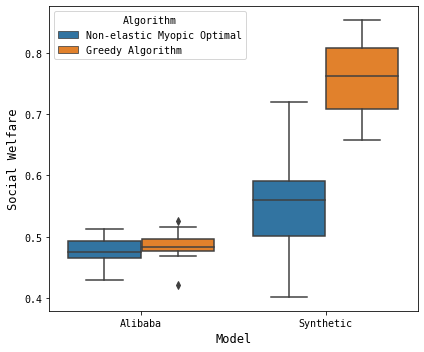

In [29]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(x='Model', y='Social Welfare', hue='Algorithm', data=online_df, ax=ax)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Social Welfare', fontsize=12)
plt.tight_layout()
save_plot('online_resource_allocation')